<a href="https://colab.research.google.com/github/Bundaberg-Joey/ML4MC/blob/main/coulomb_matrix_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEMPLATE FILE 
* Run the first cell to install all dependencies, download all data, and process all molecules into needed lists
* **SAVE A COPY TO GITHUB WITH A DIFFERENT NAME OR THIS WILL BE OVERWRITTEN**

In [ ]:
# RUN THIS CELL 

! pip install ase

# -------------------------------------------------------

import io
from datetime import datetime
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from ase.io import read
from sklearn.model_selection import train_test_split

def download_published_data():
  """Downloads and unzips data folder.
  """


  start = datetime.now()
  print(start)
  r = requests.get('https://people.bath.ac.uk/crh53/m1507656.zip')
  zipped = zipfile.ZipFile(io.BytesIO(r.content))
  zipped.extractall('')
  finish = datetime.now()
  print(finish)
  print(finish - start)

def xyz_str_to_atoms(xyz_str):
  """
  Convert a xyz file to an ASE atoms object via in-memory file (StringIO).
  """
  f = io.StringIO()
  f.write(xyz_str)
  f.seek(0)
  atoms = read(f, format="xyz")
  return atoms

# -------------------------------------------------------

print('Downloading data...')
download_published_data()  # downloads needed data
% cd m1507656

print('Loading data...')
df = pd.read_json('df_5k.json', orient='split')

print('Generating `ase.Atoms` objects...')
df['atoms'] = df['xyz_pbe_relaxed'].apply(xyz_str_to_atoms)


     |████████████████████████████████| 143 kB 5.1 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
     |████████████████████████████████| 2.2 MB 40.7 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
  Created wheel for dscribe: filename=dscribe-1.1.0-cp37-cp37m-linux_x86_64.whl size=4339833 sha256=1da043d0a6fef6aa2fd21f6e842353a1730243482f459f984cd00e8c69c67761
  Stored in directory: /root/.cache/pip/wheels/05/f8/a6/c5328c447d56d1efed920c372cbd0086ac1e01de1b5adaa9db
Successfully built dscribe
2021-08-18 09:30:13.371820
2021-08-18 09:30:39.313003
0:00:25.941183
/content/m1507656
Loading data...
Generating `ase.Atoms` objects...
Extracting HOMO, LUMO, BANDGAP from data...
err FOVWES
err FOWGIH
err FOYJUZ
err FUNBUL
err FUPZAR
err FUXFAG
err GANSAQ
err GAQCEI
err NUFRUB
err GEPHEO
err GERGOB
err GETBUD
err GEVDAN
err GEYQAC
err GIDQAN
err GIMPUO
err GISBOA
err NUNJAH
err NUNJEL
err NUNKEM
err GODBUW
err NUQCIM
err WEBWUV
err GUCLIA
err GUMBEV
err HACGAT
err

## Helpful variables
>* Needed if you need to list all elements included in your train and testing datasets

In [ ]:
atomic_numbers = df['atoms'].apply(lambda x: x.numbers)
unique_atomic_numbers = set([a for b in atomic_numbers for a in b])
max_num_atoms = atomic_numbers.apply(len).max()

print(unique_atomic_numbers)
print(max_num_atoms)

{1, 34, 35, 33, 5, 6, 7, 8, 9, 3, 14, 15, 16, 17, 53}
100


## Create your feature from `dscribe` below
* Example is given for coulomb matrix
* You will need to change the feature imported to be your one and alter any input parameters as needed

In [ ]:
from dscribe.descriptors import CoulombMatrix  # change this to be your feature

feature_calc = CoulombMatrix(n_atoms_max=max_num_atoms,)  # change also

In [ ]:
print('Generating features...')
X_train, X_test = (np.vstack([feature_calc.create(a) for a in d]) for d in (train_atoms, test_atoms))
print('Features generated.')

Generating features...
Features generated.


___
## Model training / assessment goes below
* simple example shown using `KRR` and an `RBF` kernel
* Will try to predict the `HOMO` energy level

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
y_train = train['HOMO'].values  # extract target value from dataframe

In [ ]:
# split the training data again intor training and cross validation sets
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
model = KernelRidge(kernel='rbf')
parameters = {'alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(model, param_grid=parameters, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3, verbose=1)

In [ ]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
estimator = grid.best_estimator_
print(F'Optimal alpha value from range is : {estimator.alpha}')

Optimal alpha value from range is : 0.001


In [ ]:
estimator.fit(X_tr, y_tr)

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=None, kernel='rbf',
            kernel_params=None)

In [ ]:
y_pred_tr = estimator.predict(X_tr)
y_pred_cv = estimator.predict(X_cv)

In [ ]:
for s, pred, ref in zip(('train', 'cv'), (y_pred_tr, y_pred_cv), (y_tr, y_cv)):
  mse = mean_squared_error(ref, pred)
  r2 = r2_score(ref, pred)

  print(F'{s} : mse={mse:.3f}, r2={r2:.3f}')

train : mse=0.000, r2=1.000
cv : mse=26.362, r2=-40.037


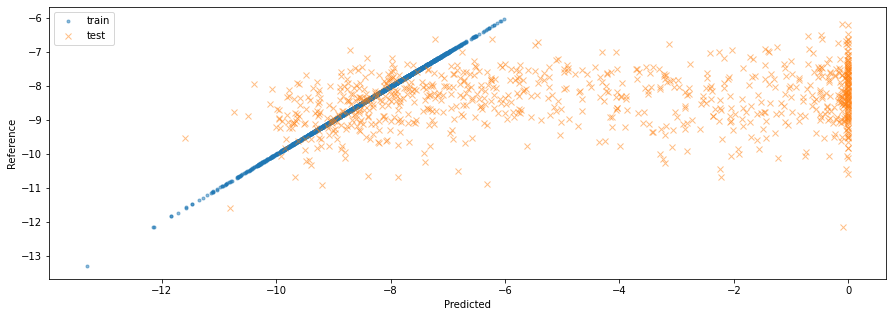

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_pred_tr, y_tr, '.', alpha=0.5, label='train')
plt.plot(y_pred_cv, y_cv, 'x', alpha=0.5, label='test')
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.legend()
plt.show()

* Can see model has significnatly overfitted to the data